# Predictive Maintenance 
## Kayleigh James


### Importing Data

Data from Kaggle: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("predictive_maintenance.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [2]:
df.head(8)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure


### Data Cleaning

Before beginning exploratory data analysis we need to clean the data.  We will drop any observations that have null values.  We will also drop duplicates.

In [3]:
df = df.dropna()
df = df.drop_duplicates()
df.shape

(10000, 10)

The number of rows in the dataframe did not decrease so there were no nulls or duplicates in the data set.  Had there been null values, we could have used feature imputation instead of dropping the rows.

There are two ways of identifying the tools in the dataset - UDI (Unique Identifier) and Product ID.  I will be dropping the Product ID column as it is redundant to the UDI.  Additionally Product ID is a string (there are letters in the ID) so it would have needed to be encoded in order to perform future analysis.

In [4]:
df = df.drop(["Product ID","UDI"], axis = 1)

(10000, 8)

### Balancing Classes

Target is very unbalanced - 9,661 observations are 0 and 339 are 1.  We will upsample the minority class.

In [5]:
from sklearn.utils import resample

df_majority = df[df.Target==0]
df_minority = df[df.Target==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=1000,    
                                 random_state=123) 
 

df = pd.concat([df_majority, df_minority_upsampled])
df.Target.value_counts()

0    9661
1    1000
Name: Target, dtype: int64

This dataset contains 8 features and two different target variables.  The column called "Target" is either 0 or 1.  If Target is 0 then the machine did not fail; if it has a value of 1 then the machine did fail.  This will be a binary classification problem.

The column called "Failure Type" is a categorical feature with 6 possible values.  If the machine did not fail (i.e. the Target column has a value of 0) then the Failure Type will be "No Failure".  The other 5 possible values are Heat Dissipation Failure, Overstrain Failure, Power Failure, Random Failures, and Tool Wear Failure.  This is a multiclass classification problem.

We will create two separate dataframes for the two problems.  If we included Failure Type in the binary classification problem as a feature it would lead to data leakage (e.g. if Failure Type was "No Failure" then we know Target would be 0) and vice versa.

In [6]:
df_binary = df.drop("Failure Type", axis = 1)
print(df_binary.shape)
df_binary.head()

(10661, 7)


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [7]:
df_multi = df.drop("Target", axis = 1)
print(df_multi.shape)
df_multi.head()

(10661, 7)


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,M,298.1,308.6,1551,42.8,0,No Failure
1,L,298.2,308.7,1408,46.3,3,No Failure
2,L,298.1,308.5,1498,49.4,5,No Failure
3,L,298.2,308.6,1433,39.5,7,No Failure
4,L,298.2,308.7,1408,40.0,9,No Failure


### Data Visualizations

Text(0.5, 1.0, 'Class Imbalance - Target')

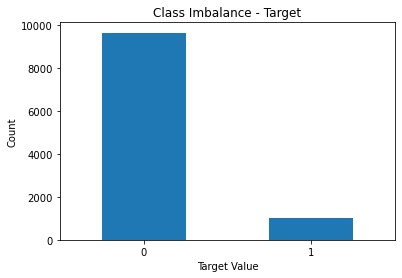

In [8]:
import matplotlib.pyplot as plt

df['Target'].value_counts().plot(kind='bar', rot=0)
plt.xlabel("Target Value")
plt.ylabel("Count")
plt.title("Class Imbalance - Target")

In [9]:
df["Target"].value_counts()

0    9661
1    1000
Name: Target, dtype: int64

Text(0.5, 1.0, 'Class Imbalance - Failure Type')

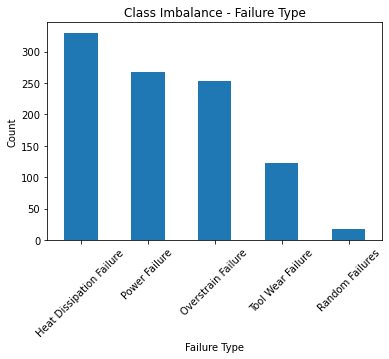

In [10]:
df2 = df.loc[df['Failure Type'] != "No Failure"]
df2["Failure Type"].value_counts().plot(kind='bar', rot=45)
plt.xlabel("Failure Type")
plt.ylabel("Count")
plt.title("Class Imbalance - Failure Type")

In [11]:
df["Failure Type"].value_counts()

No Failure                  9669
Heat Dissipation Failure     330
Power Failure                268
Overstrain Failure           254
Tool Wear Failure            122
Random Failures               18
Name: Failure Type, dtype: int64

In [12]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10661.000000,10661.000000,10661.000000,10661.000000,10661.000000,10661.000000
mean,300.057893,310.026498,1536.627802,40.607448,110.061533,0.093800
std,2.018903,1.482892,200.370186,10.741061,64.838985,0.291564
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.400000,308.800000,1412.000000,33.400000,54.000000,0.000000
50%,300.200000,310.100000,1496.000000,40.600000,110.000000,0.000000
75%,301.600000,311.100000,1608.000000,47.700000,166.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


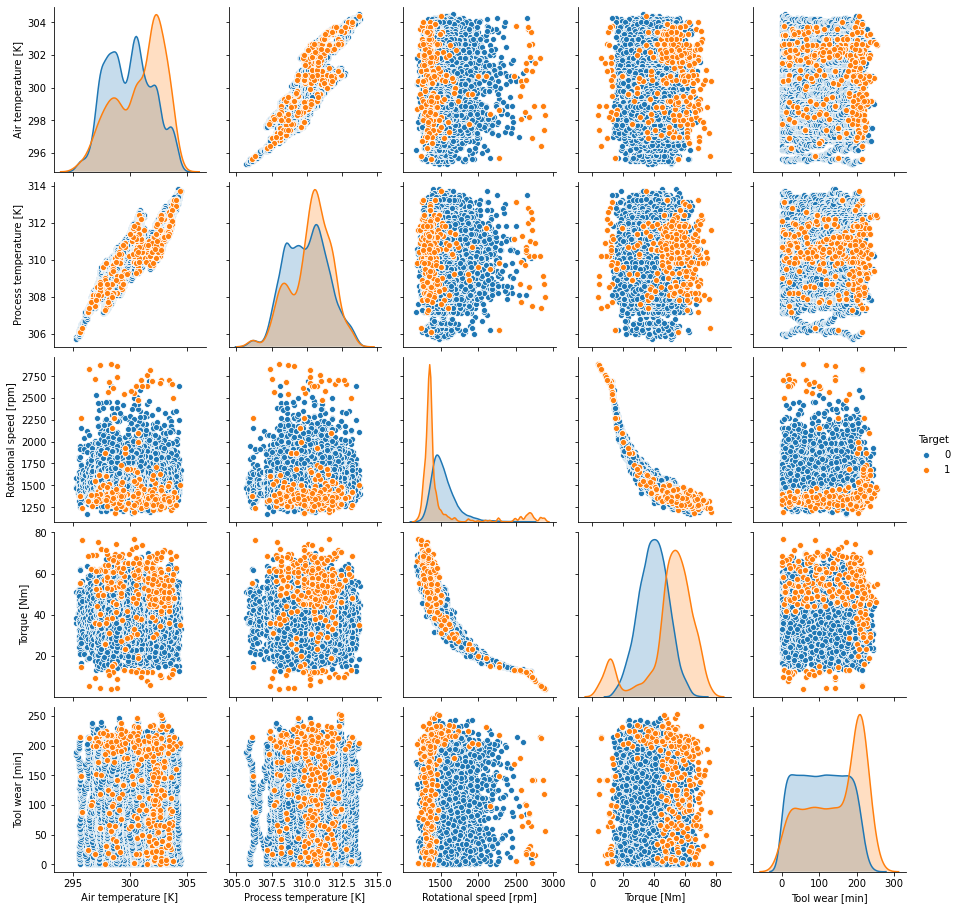

In [13]:
import seaborn as sns

data = df[["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]","Target"]]
sns.pairplot(data, hue="Target")

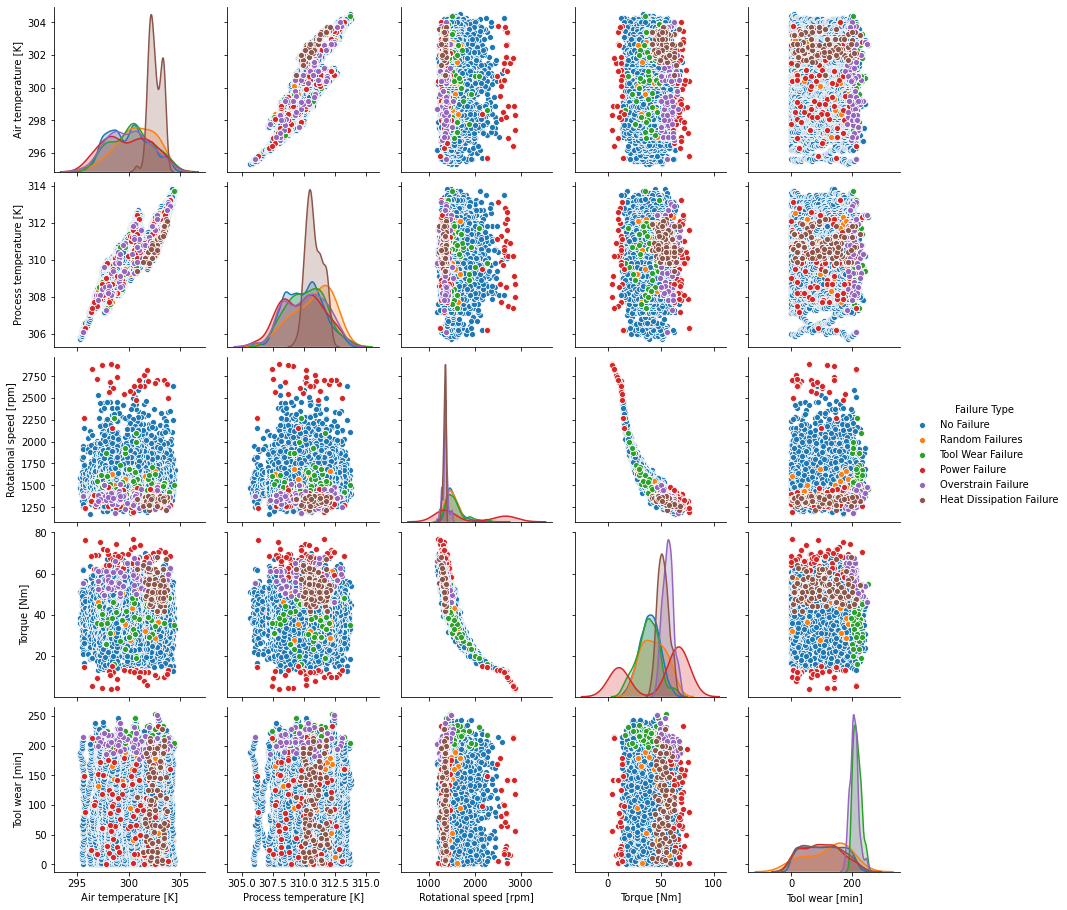

In [14]:
data = df[["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]","Failure Type"]]
sns.pairplot(data, hue="Failure Type")

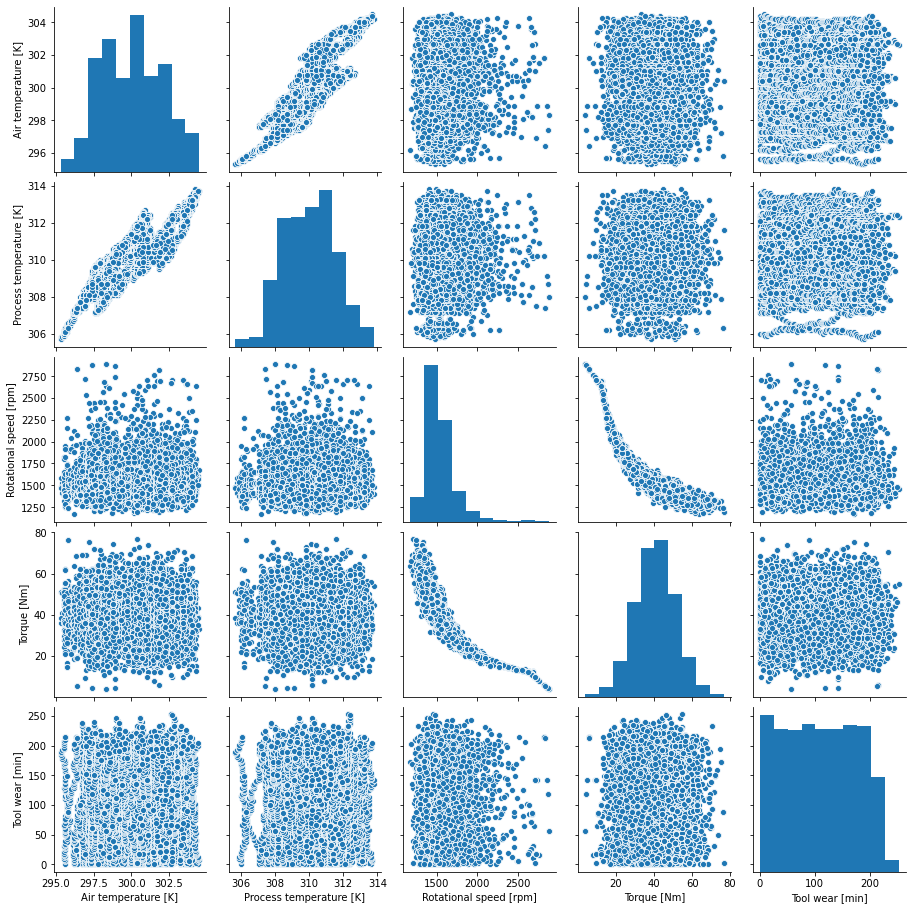

In [15]:
data = df[["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"]]
sns.pairplot(data)

### Feature Scaling and Encoding

We need to scale the features as Gradient Descent and Distance based algorithms are sensitive to scaling (Tree Based Algorithms are insensitive to different scaling between features).  We will be normalizing instead of standardizing because our data does not follow a Gaussian distribution.  Since the target variables do not need to be normalized we will separate the data frames into an X (features/independent variables) and a y (target/dependent variable).  

In [16]:
X_binary = df_binary[["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]","Type"]]
y_binary = df_binary["Target"]

X_multi = df_multi[["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]","Type"]]
y_multi = df_multi["Failure Type"]

We also will need to deal with the categorical variable "Type".  We will be handling this with one hot encoding which creates a new feature for each value of the categorical feature.  There will be a one in the newly created feature corresponding to the original categorical value the observation had and a 0 in all of the other newly created features.  This can lead to a sparse matrix and introduce the curse of dimensionality, however, there are a small number of unique value for type and quite a few observations so I don't believe this will be an issue.

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (OneHotEncoder(), ['Type']),
    remainder='passthrough')

transformed = transformer.fit_transform(X_multi)
X_multi = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)
transformed = transformer.fit_transform(X_binary)
X_binary = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)

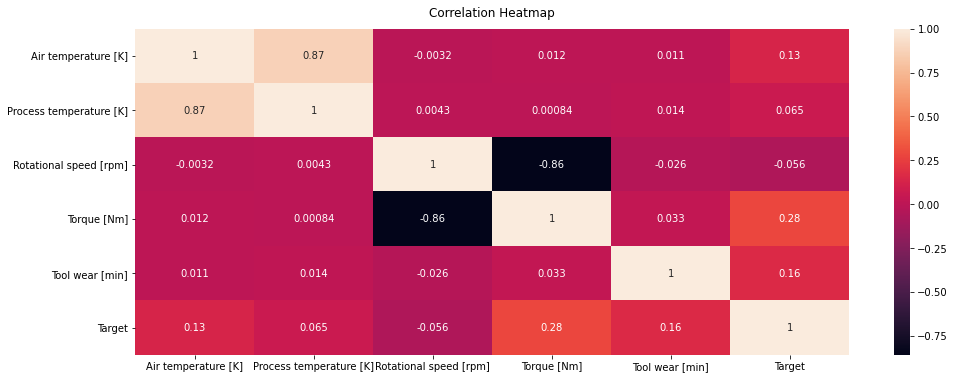

In [18]:
import seaborn as sns

plt.figure(figsize=(16, 6))
data = df[["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]","Target"]]
heatmap = sns.heatmap(data.corr(), annot=True);
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(X_binary.values), columns=X_binary.columns, index=X_binary.index)
pd.DataFrame(scaler.fit_transform(X_multi.values), columns=X_multi.columns, index=X_multi.index)

,onehotencoder__x0_H,onehotencoder__x0_L,onehotencoder__x0_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0.0,0.0,1.0,0.304348,0.358025,0.222934,0.535714,0.000000
1,0.0,1.0,0.0,0.315217,0.370370,0.139697,0.583791,0.011858
2,0.0,1.0,0.0,0.304348,0.345679,0.192084,0.626374,0.019763
3,0.0,1.0,0.0,0.315217,0.358025,0.154249,0.490385,0.027668
4,0.0,1.0,0.0,0.315217,0.370370,0.139697,0.497253,0.035573
...,...,...,...,...,...,...,...,...
10656,0.0,1.0,0.0,0.804348,0.592593,0.055297,0.879121,0.778656
10657,0.0,1.0,0.0,0.445652,0.370370,0.161816,0.811813,0.529644
10658,1.0,0.0,0.0,0.945652,0.925926,0.059953,0.890110,0.636364
10659,1.0,0.0,0.0,0.728261,0.506173,0.065192,0.734890,0.581028


### Feature Selection

In [20]:
X_multi = X_multi.drop(["Air temperature [K]","Rotational speed [rpm]"], axis = 1)
X_binary = X_binary.drop(["Air temperature [K]","Rotational speed [rpm]"], axis = 1)

### Test/Train Split

In [21]:
from sklearn.model_selection import train_test_split

#create holdout sets
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(X_multi, y_multi,
                                                    stratify=y_multi, 
                                                    test_size=0.30)
X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(X_binary, y_binary,
                                                    stratify=y_binary, 
                                                    test_size=0.30)

#split holdout sets into validation and training sets
X_multi_val, X_multi_test, y_multi_val, y_multi_test = train_test_split(X_multi_test, y_multi_test,
                                                    stratify=y_multi_test, 
                                                    test_size=0.50)
X_binary_val, X_binary_test, y_binary_val, y_binary_test = train_test_split(X_binary_test, y_binary_test,
                                                    stratify=y_binary_test, 
                                                    test_size=0.50)

y_binary_test.value_counts()

0    1450
1     150
Name: Target, dtype: int64

### Model Training

All classifiers in scikit-learn do multiclass classification out-of-the-box. You don’t need to use the sklearn.multiclass module unless you want to experiment with different multiclass strategies.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Logistic Regression"
]
classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=7),
    LogisticRegression(random_state=0)
]

print("Binary Classification")
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_binary_train, y_binary_train)
    y_pred = clf.predict(X_binary_val)
    score = f1_score(y_binary_val, y_pred)
    print(name)
    print(score)

print("MultiClass Classification")
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_multi_train, y_multi_train)
    y_pred = clf.predict(X_multi_val)
    score = f1_score(y_multi_val, y_pred, average='weighted')
    print(name)
    print(score)

Binary Classification
Nearest Neighbors
0.7227414330218069
Linear SVM
0.0
RBF SVM
0.924731182795699
Decision Tree
0.6294820717131474
Logistic Regression
0.20238095238095238
MultiClass Classification
Nearest Neighbors
0.941206403022862
Linear SVM
0.8954859048321938
RBF SVM
0.9802543361534791
Decision Tree
0.9278195217625619
Logistic Regression
0.8916181468171868


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Model Selection

### Hyperparameter Tuning

In [23]:
from sklearn.model_selection import GridSearchCV

dt = SVC(random_state=29)
params = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

GS = GridSearchCV(estimator=dt,param_grid=params,cv=5,n_jobs=-1, verbose=True, scoring='f1')
GS.fit(X_binary_train, y_binary_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=SVC(random_state=29), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='f1', verbose=True)

In [24]:
print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)

Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Best Score: 0.9018689701870037


In [25]:
y_pred_binary = GS.predict(X_binary_test)
score = f1_score(y_binary_test, y_pred_binary)
print(score)

0.9305555555555556


In [26]:
GS = GridSearchCV(estimator=dt,param_grid=params,cv=5,n_jobs=-1, verbose=True, scoring='f1_weighted')
GS.fit(X_multi_train, y_multi_train)
print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)
y_pred_multi = GS.predict(X_multi_test)
score = f1_score(y_multi_test, y_pred_multi, average='weighted')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Best Score: 0.9821563640132946


### Final Model Evaluation

Binary Classification w/ Best RBF SVM
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1450
           1       0.97      0.89      0.93       150

    accuracy                           0.99      1600
   macro avg       0.98      0.95      0.96      1600
weighted avg       0.99      0.99      0.99      1600



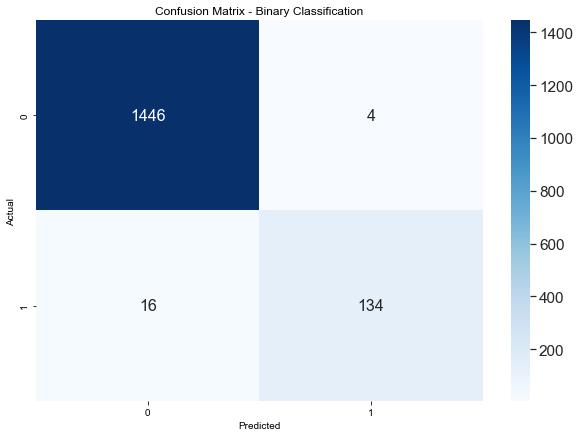

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

print("Binary Classification w/ Best RBF SVM")
print(classification_report(y_binary_test, y_pred_binary))

data = confusion_matrix(y_binary_test, y_pred_binary)

df_cm = pd.DataFrame(data, columns=np.unique(y_binary_test), index = np.unique(y_binary_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix - Binary Classification")
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 16})




Multiclass Classification w/ Best RBF SVM
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.98      0.92      0.95        50
              No Failure       0.99      1.00      0.99      1451
      Overstrain Failure       1.00      0.89      0.94        38
           Power Failure       1.00      0.95      0.97        41
         Random Failures       0.00      0.00      0.00         2
       Tool Wear Failure       0.83      0.83      0.83        18

                accuracy                           0.99      1600
               macro avg       0.80      0.77      0.78      1600
            weighted avg       0.99      0.99      0.99      1600



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


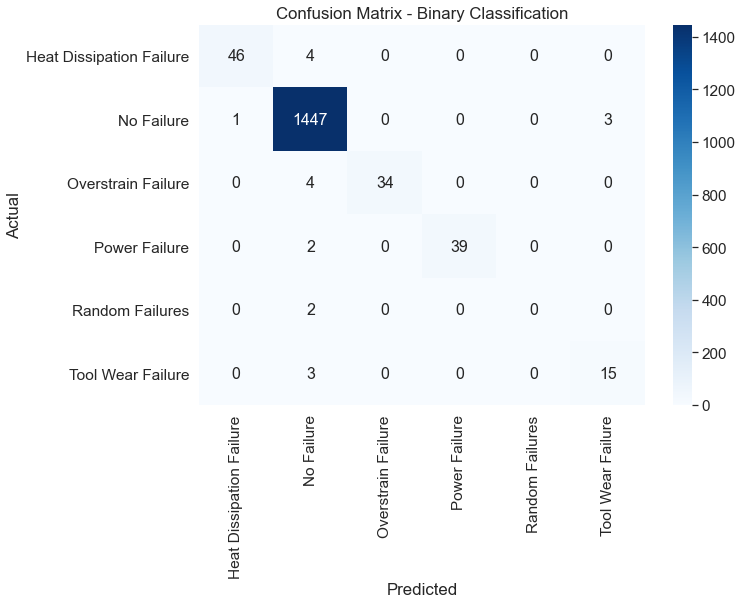

In [28]:
print("\n")
print("Multiclass Classification w/ Best RBF SVM")
print(classification_report(y_multi_test, y_pred_multi))

data = confusion_matrix(y_multi_test, y_pred_multi)

df_cm = pd.DataFrame(data, columns=np.unique(y_multi_test), index = np.unique(y_multi_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix - Binary Classification")
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='d',annot_kws={"size": 16})